# Principal component analysis of Biological data

In [4]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth


from scipy import stats
from scipy.stats import beta


import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

This post is going to be about KDE-based classificaiton for genomics.

To warm up, we're just going to review the application of this algorithm. Because it is 
the same as used in other contexts, i thought it would be interesting to apply it to simulated
haplotypes instead of generated clouds. In practice, once the transition to feature space is made, 
we're sailing the same waters.

In a previous post, i have toyed with simulating haplotypes for different populations. 

Let's do that again, but this time we will save some haplotypes as incognita.

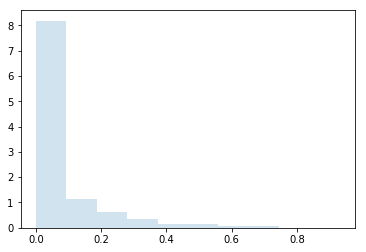

In [5]:
# First we'll look at what our simulated allele frequencies will look like:

a, b = 2.5, .2
r= beta.rvs(a, b, size=1000)
r= [1-x for x in r] 

fig, ax = plt.subplots(1, 1)
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)
plt.show()

In [9]:
## Now for the population structure

# number of populations to generate
N_pops= 3

# length of haplotypes
L= 200

# Size of each population
Sizes= [250,100,300]

# number of unlabelled individuals to draw from each population:
n_unlab= [15,3,20]

# population labels
labels= np.repeat(np.array([x for x in range(N_pops)]),Sizes)

data= []

## save the probability vectors that will characterize each population:
prob_vectors= np.array([beta.rvs(a, b, size=L) for x in range(N_pops)])

for k in range(N_pops):
    
    probs= prob_vectors[k,:]
    probs[(probs > 1)]= 1 ## probabilities exceeding 1 are trimmed.
    
    m= Sizes[k]
    
    Haps= [[np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)] for acc in range(m)]
    
    data.extend(Haps)

data= np.array(data)

## create incognita haplotypes from our populations:
admixed= {k:[[np.random.choice([1,0],p= [1-prob_vectors[k,:][x],prob_vectors[k,:][x]]) for x in range(L)] for acc in range(n_unlab[k])] for k in range(N_pops)}

print("'Known' haplotypes generated: {0}".format(data.shape[0]))
print("incognita generated: {0}".format(sum(n_unlab)))
print("Haplotype length: {0}".format(L))

'Known' haplotypes generated: 650
incognita generated: 38
Haplotype length: 200


In [10]:
## Principal component analysis of the data generated.
n_comp = 4

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(data)
features = pca.transform(data)

print("Variance explained:")
print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))

Variance explained:
PC1: 0.17; PC2: 0.048; PC3: 0.017; PC4: 0.017


In [12]:
## lets now visualize the result:

## Our reference populations
fig_data= [go.Scatter3d(
        x = features[[x for x in range(sum(Sizes)) if labels[x] == i],0],
        y = features[[x for x in range(sum(Sizes)) if labels[x] == i],1],
        z = features[[x for x in range(sum(Sizes)) if labels[x] == i],2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      },
      name= str(i)
    ) for i in range(N_pops)]


## The incognita:
admx_t= [y for y in it.chain(*admixed.values())] 
admx_t= np.array(admx_t)
admx_t= pca.transform(admx_t)

fig_data.append(
    go.Scatter3d(
        x = admx_t[:,0],
        y = admx_t[:,1],
        z = admx_t[:,2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'color':'rgb(0,0,0)',
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      },
      name= 'unlabelled'
    ))

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


### Classification.
    We are finally at this step. Our aim here is just to assign our "unknowns" to known populations. 
In this particular scenario - if the beta parameter has not been risen too far, this could be achieved using any distance-based method of assignment. However, the extended usefulness of the KDE-based approach will become apparent in later posts.

In [13]:

global_data= np.vstack((admx_t,features))

params = {'bandwidth': np.linspace(np.min(features), np.max(features),20)}
grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)

Scores= []

for lab in list(set(labels)):
    grid.fit(features[[x for x in range(len(labels)) if labels[x] == lab],:])
    kde = grid.best_estimator_
    
    P_dist = kde.score_samples(features[[x for x in range(len(labels)) if labels[x] == lab],:])
    Fist = kde.score_samples(global_data)

    Fist = scipy.stats.norm(np.mean(P_dist),np.std(P_dist)).cdf(Fist)
    Scores.append(Fist)


Scores= np.array(Scores).T

new_labels= np.argmax(Scores,axis= 1)

print('First twenty assignments:')
print(new_labels[:20])

First twenty assignments:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2]


Good! we've got a new set of labels. let's see how they hold up to our expectations.

In [15]:
fig_features= [go.Scatter3d(
        x = global_data[[x for x in range(len(new_labels)) if new_labels[x] == i],0],
        y = global_data[[x for x in range(len(new_labels)) if new_labels[x] == i],1],
        z = global_data[[x for x in range(len(new_labels)) if new_labels[x] == i],2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      },
      name= str(i)
    ) for i in list(set(new_labels))]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_features, layout=layout)
py.iplot(fig)


Good! our unlabelled individuals are now classed to the populations they were actually drawn from. that's a good thing.